# Setup

## Basic imports and constants

In [136]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from openimages2019 import setup as st
from openimages2019 import utils as u

from skimage.draw import rectangle

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATA_DIR = os.path.join(ROOT_DIR, "../data")

#Make only 1 GPU visible
!export HIP_VISIBLE_DEVICES=0

#Set which GPU devices' memory should be accessible to running GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




## Partition the classes according to frequency

In [ ]:
class_sets = st.partition_classes()

## Core Functions

In [189]:
class TrainConfig(Config):
    
    NAME = "kaggle"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    
def get_infer_model(config, model_path=None):
    inf_model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

    if model_path is None:
        model_path = inf_model.find_last()
        
    inf_model.load_weights(model_path, by_name=True)
    
    return inf_model


def load_member_models(model_paths, class_sets, images_per_gpu=1):
    models = []

    for i,mpath in enumerate(model_paths):

#         class KaggleConfig(TrainConfig):
#             NUM_CLASSES = len(class_sets[i])+ 1 # + 1 for background class

#         class InferenceConfig(KaggleConfig):
#             GPU_COUNT = 1
#             IMAGES_PER_GPU = 1
# #             IMAGES_PER_GPU = images_per_gpu
#             DETECTION_MIN_CONFIDENCE = 0.75
    
        class InferenceConfig(TrainConfig):
            NUM_CLASSES = len(class_sets[i])+ 1 # + 1 for background class
            DETECTION_MIN_CONFIDENCE = 0.75

        inf_config = InferenceConfig()

        print("loading model: ", mpath )
        model = get_infer_model(inf_config,model_path=mpath)
        
        models.append(model)
        
    return models


def assemble(ind_results, iou_threshold=0.5):
    """ Combines the results from many different models across a single images.  Uses NMS to handle overlaps"""

    classes = np.concatenate([x['class_ids'] for x in ind_results])
    scores = np.concatenate([x['scores'] for x in ind_results])

    rois = np.concatenate([x['rois'] for x in ind_results],axis = 0)

    #TODO just to display stuff ... not needed here
    masks = np.concatenate([x['masks'] for x in ind_results],axis = 2)

    if len(scores) > 0:
#         to_keep = range(len(scores)) #don't use NMS
        to_keep = utils.non_max_suppression(rois, scores, iou_threshold)
        rval = {'class_ids' : classes[to_keep], 'rois' : rois[to_keep],
            'scores' : scores[to_keep], 'masks' : masks[:,:,to_keep]}
    else:
        rval = {'class_ids' : [], 'rois' : [], 'scores' : [], 'masks' : []}
#         Should make these empty np.arrays ... maybe?

    return rval


def ensemble_detect(models, images, batch_size, id_offsets):
    """
    
    For each model, run inference on image batches.  Then groups inference results by image and 
    applys non maximum suppression (via assemble method) to each group.
    
    """
    all_results = [[] for x in images]

    for midx,model in enumerate(models):

        results = []
        
        # Have to do this because of model.detect batch size assertion
        for j in range(0,len(images),batch_size):
            results += model.detect(images[j:j+batch_size], verbose=0)

        for i in range(len(results)):
            r = results[i]

            r['model_id'] = midx
            r['class_ids'] += id_offsets[midx]

            all_results[i].append(r)
            
    return [assemble(x) for x in all_results]
    

# Inference

## Member model label ids --> ensemble model label ids

In [117]:
background = ['/mnull','Background']
    
z = [np.insert(cset[['LabelName','LabelDescription']].values,0,background,axis=0) for cset in class_sets]

omni_class_set = pd.DataFrame(np.concatenate(z),columns=['LabelName','LabelDescription'])
omni_class_set['LabelID'] = omni_class_set.index

id_offsets = omni_class_set[omni_class_set['LabelName'] == '/mnull'].index.values

## Load models

In [118]:
model_paths = [os.path.join(DATA_DIR,'models','cset_' + str(i) + '_model.h5') for i in range(6)]

models = load_member_models(model_paths, class_sets)

loading model:  /home/nbuser/repo/../data/models/cset_0_model.h5
loading model:  /home/nbuser/repo/../data/models/cset_1_model.h5
loading model:  /home/nbuser/repo/../data/models/cset_2_model.h5
loading model:  /home/nbuser/repo/../data/models/cset_3_model.h5
loading model:  /home/nbuser/repo/../data/models/cset_4_model.h5
loading model:  /home/nbuser/repo/../data/models/cset_5_model.h5


## Simple demo

### Run inference on tiny set

In [ ]:
img = skimage.io.imread(os.path.join(DATA_DIR, 'train/2fef4dd2f83feb18.jpg'))
img2 = skimage.io.imread(os.path.join(DATA_DIR, 'train/55dee1384cd565ee.jpg'))

images = [img,img2]

detected = ensemble_detect(models, images,2, id_offsets)

### Visualize

In [ ]:
for i,r in enumerate(detected):
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'], show_mask=False)

## Evaluate

### Build the validation data set

In [ ]:
anns = st.load_annotations_by_image()

#down select to our validation data
val_anns = anns[anns['RelativePath'].str.contains('validation',regex=False)]

#get rid of the old labelId
val_anns.drop(columns='LabelID',inplace=True)

# join with tmp_set_classes on LabelName to get updated LabelID
anns_by_image = pd.merge(val_anns,omni_class_set, on='LabelName',how='inner')

anns_grouped = anns_by_image.groupby('ImageID')

# validation dataset
dataset = st.FullKaggleImageDataset()
dataset.add_classes(omni_class_set.iloc[1:])  # do not add first background
dataset.load_kaggle_images(DATA_DIR, anns_grouped)
dataset.prepare()

### Visually validate dataset creation

In [ ]:
# Load and display random samples ... sanity check for data load
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### Calculate mAP

#### Define functions

In [112]:
def calc_mAP(models, config, batch_size=1, sample_size=50):
    
    assert sample_size%batch_size == 0, 'Sample size must be divisible by batch_size'

    image_ids = np.random.choice(dataset.image_ids, sample_size)

    #each input is a tuple of form : image, image_meta, gt_class_id, gt_bbox, gt_mask
    inputs = [modellib.load_image_gt(dataset, config, iid, use_mini_mask=False) for iid in image_ids]

    APs = []

    results = ensemble_detect(models, [inp[0] for inp in inputs],batch_size, id_offsets)

    for j in range(len(results)):
        r = results[j]
        # Compute AP
        
        if len(r["rois"]) > 0: # function has bug, errors when nothing is found in an image ... so we ignore those for now
            AP, precisions, recalls, overlaps = utils.compute_ap(inputs[j][3], inputs[j][2], inputs[j][4], 
                                                r["rois"], r["class_ids"], r["scores"], r['masks'])
            APs.append(AP)

    return np.mean(APs)



class KaggleConfig(TrainConfig):
    NUM_CLASSES = len(omni_class_set)
    
class InferenceConfig(KaggleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 


#### Run the function

In [113]:
calc_mAP(models, InferenceConfig(),sample_size=250)

0.189658603130291

### Visualize some validation samples

In [ ]:
config = InferenceConfig()
batch_size=2

#### Start code for sample ... real file should include entire test set ####
sample_size=50 #todo this shouldn't be used, should be all of the training data
    
assert sample_size%batch_size == 0, 'Sample size must be divisible by batch_size'

image_ids = np.random.choice(dataset.image_ids, sample_size)

#each input is a tuple of form : image, image_meta, gt_class_id, gt_bbox, gt_mask
inputs = [modellib.load_image_gt(dataset, config, iid, use_mini_mask=False) for iid in image_ids]

images = [inp[0] for inp in inputs]

#### End code for sample ... real file should include entire test set ####


results = ensemble_detect(models, images,batch_size, id_offsets)

In [ ]:
cnt = 0

for i,r in enumerate(results):
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'], show_mask=False)
    
    cnt += 1
    
    if cnt > 5:
        break

## Generate kaggle submission file

### Run inference on test set, batched writes (latest)

In [198]:
from PIL import ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

#TODO image_info should be 2d array, with each row of form id, width, height
def append_to_file(results, image_info):
    
    all_preds = []
    
    for j, r in enumerate(results):
        preds = []
        ids = r['class_ids']
        boxes = r['rois']
        scores = r['scores']

        img_id = image_info[j][0]
        height = image_info[j][2]
        width = image_info[j][1]
        
        preds = ''

        for i in range(len(r['class_ids'])):
            xmin = max(boxes[i][1] / width , 0.0)
            ymin = max(boxes[i][0] / height, 0.0)
            xmax = min(boxes[i][3] / width, 1.0)
            ymax = min(boxes[i][2] / height, 1.0)
            
            preds += " " + " ".join(map(str,[omni_class_set.iloc[ids[i]]['LabelName'], scores[i], xmin,ymin,xmax,ymax]))

        all_preds.append(img_id + "," + preds)
        
    with open(os.path.join(ROOT_DIR, 'submission.csv'), 'a') as f: 
        f.write('\n'.join(all_preds))
        f.write('\n')
    
    

testdir = os.path.join(DATA_DIR, "test")
batch_size = 500


def write_sub_file(start_index=0):
    results = []
    image_info = []


    for subdir, dirs, files in os.walk(testdir):
        for cnt,file in enumerate(files):

            #use this if the process broke down at some point and you need to restart midway through ... total hack
            if cnt < start_index:
                continue

            img = skimage.io.imread(os.path.join(subdir, file))

            #filename, width, height
            image_info.append([file[:-4],img.shape[1],img.shape[0]])

            results += ensemble_detect(models, [img],1, id_offsets)

            if (cnt%batch_size == (batch_size-1)):
                print("writing to file ... ")
                append_to_file(results,image_info)
                results = []
                image_info = []
                print(cnt," completed") #100,000 images in the test set

#### Start the process from scratch

In [ ]:
# YOU ONLY WANT THIS IN PLACE FOR THE FIRST RUN ... afterwards it will wipe the file ... NOT GOOD !!!     
# with open(os.path.join(ROOT_DIR, 'submission.csv'), 'w+') as f:
#     f.write('ImageId,PredictionString\n')
    
write_sub_file()

# GOT TO ...
# writing to file ... 
# 69499  completed

writing to file ... 
499  completed
writing to file ... 
999  completed
writing to file ... 
1499  completed
writing to file ... 
1999  completed
writing to file ... 
2499  completed
writing to file ... 
2999  completed
writing to file ... 
3499  completed
writing to file ... 
3999  completed
writing to file ... 
4499  completed
writing to file ... 
4999  completed
writing to file ... 
5499  completed
writing to file ... 
5999  completed
writing to file ... 
6499  completed
writing to file ... 
6999  completed
writing to file ... 
27499  completed
writing to file ... 
27999  completed
writing to file ... 
28499  completed
writing to file ... 
28999  completed
writing to file ... 
29499  completed
writing to file ... 
29999  completed
writing to file ... 
30499  completed
writing to file ... 
30999  completed
writing to file ... 
31499  completed
writing to file ... 
31999  completed
writing to file ... 
32499  completed
writing to file ... 
32999  completed
writing to file ... 
33499  

#### Resume work at some file number

In [79]:
write_sub_file(start_index=65000)

### Run inference on test set

In [ ]:
import os
testdir = os.path.join(DATA_DIR, "test")

results = []

for subdir, dirs, files in os.walk(testdir):
    for i,file in enumerate(files):
        results += ensemble_detect(models, [skimage.io.imread(os.path.join(subdir, file))],1, id_offsets)
        
        if (i%10 == 0):
            print(i/1000) #100,000 images in the test set

### Visualize

In [ ]:
# TO USE THIS:
# You need to store the images above instead of loading them as a function argument

cnt = 0

for i,r in enumerate(results):
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'], show_mask=False)
    
    cnt += 1
    
    if cnt > 5:
        break   

### Build Kaggle Submission File from results

In [ ]:
#TODO This cell will probably fail in the future as it assumes that 
# the body of the calculate_mAP function was executed outside of a function so that the
# results and image_ids variables are exposed

img_ids = anns_grouped.sum().index.values

all_preds = []

#DONT KNOW ABOUT ORDERING ANYMORE ...
for j, r in enumerate(results):
    preds = []
    ids = r['class_ids']
    boxes = r['rois']
    scores = r['scores']
    
    preds = ''
    
    for i in range(len(r['class_ids'])):
        preds += " " + " ".join(map(str,[omni_class_set.iloc[ids[i]]['LabelName'], scores[i], boxes[i][1],boxes[i][0],boxes[i][3],boxes[i][2]]))
    
    iid = image_ids[j]
    
    all_preds.append(img_ids[iid] + ", " + preds[1:])


#TODO write to csv file
with open(os.path.join(ROOT_DIR, 'submission.csv'), 'w') as f: 
    f.write('ImageId,PredictionString\n')
    f.write('\n'.join(all_preds)) 

# Misc

## Visualize results for debugging

In [196]:
# random images
image_ids = np.random.choice(dataset.image_ids, 30)

# single object scenes
# image_ids = [28542,16831,26167,1290,1694]

# single object with parts scenes
# image_ids = [16020,31270,16615,16364,29407,12841,19720]

#more complicated scenes
# image_ids = [6596,14954,6081,28724,9376]

#complicated scenes
# image_ids = [30670, 4918,13704,15065,22429,8799]

ver_images = []

for iid in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inf_config, iid, use_mini_mask=False)

    #UNCOMMENT THESE LINES TO VISUALIZE
#     print(iid)
#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset.class_names, figsize=(8, 8))
    
    ver_images.append(original_image)
    
# [30670, 4918, 6596, 13792]

In [190]:
def visualize_em(image,iid,mode='all'):

    if mode == 'all' :
        for midx,model in enumerate(models):
            results = model.detect([image], verbose=0)

            for i in range(len(results)):
                r = results[i]

                r['model_id'] = midx
                r['class_ids'] += id_offsets[midx]


                visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'])

    print("----------------- ENSEMBLE ---------------------")
    eresults = ensemble_detect(models, [image],batch_size, id_offsets)
    r = eresults[0]
    
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'], show_mask=False)


    print("----------------- Ground Truth ---------------------")
    inf_config = InferenceConfig()
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inf_config, iid, use_mini_mask=False)

    # visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
    #                             dataset.class_names, figsize=(8, 8))
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,show_mask=False)


    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                    r["rois"], r["class_ids"], r["scores"], r['masks'])

    print("Average Precision: ", AP)

----------------- ENSEMBLE ---------------------


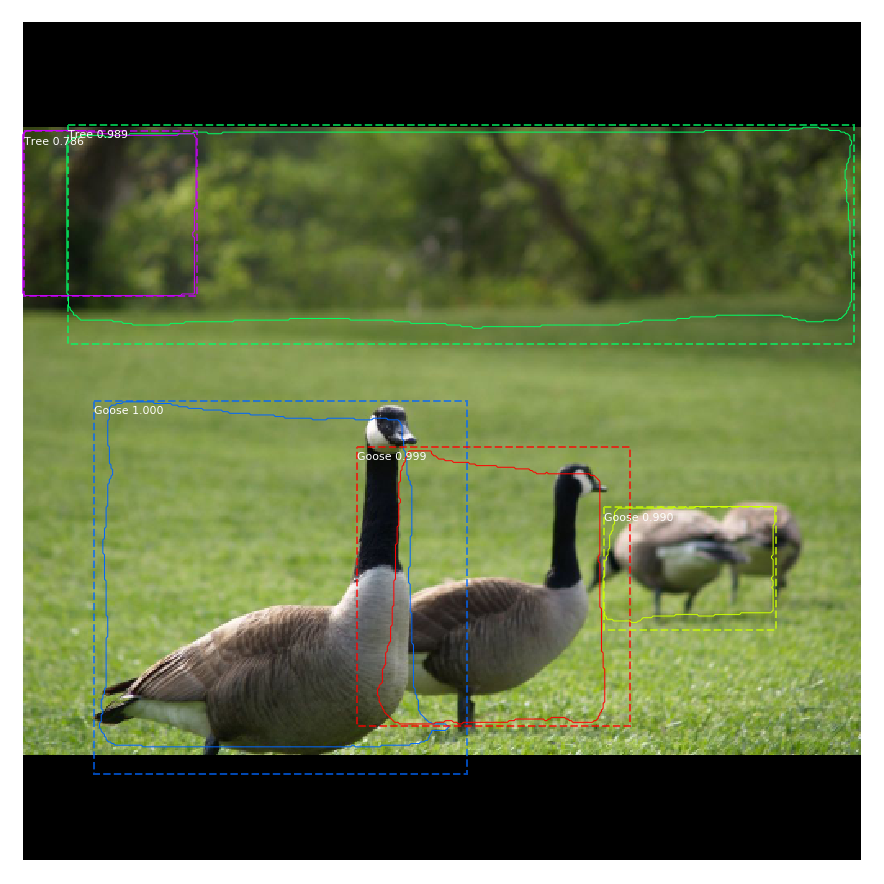

----------------- Ground Truth ---------------------


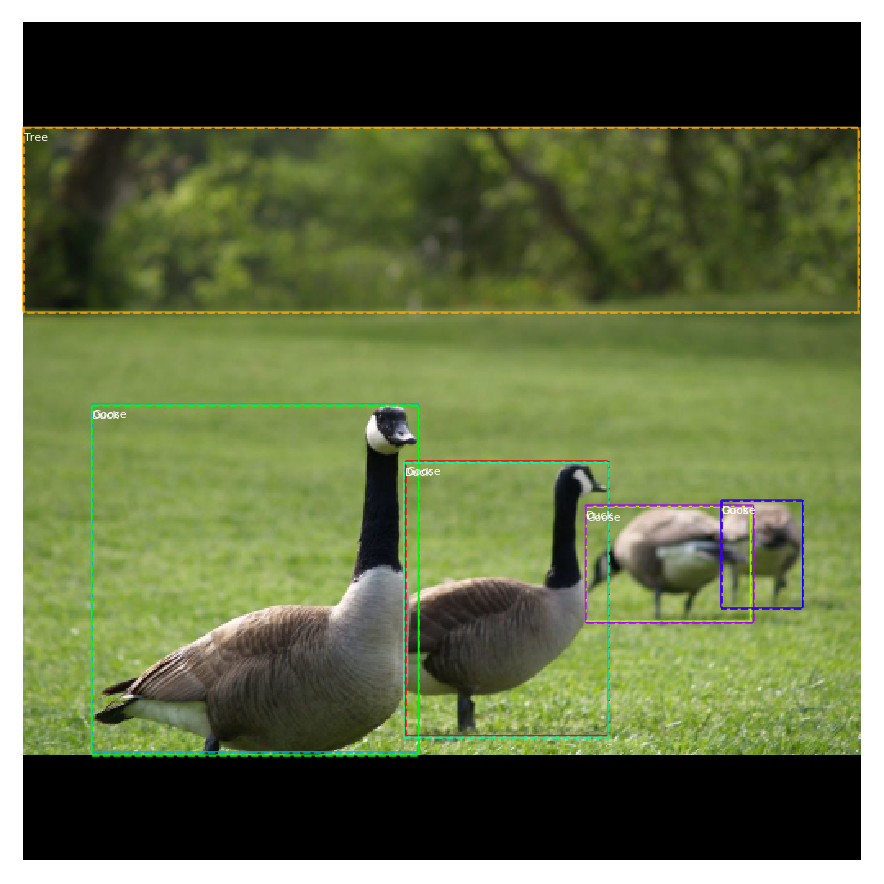

Average Precision:  0.4444444477558136
----------------- ENSEMBLE ---------------------


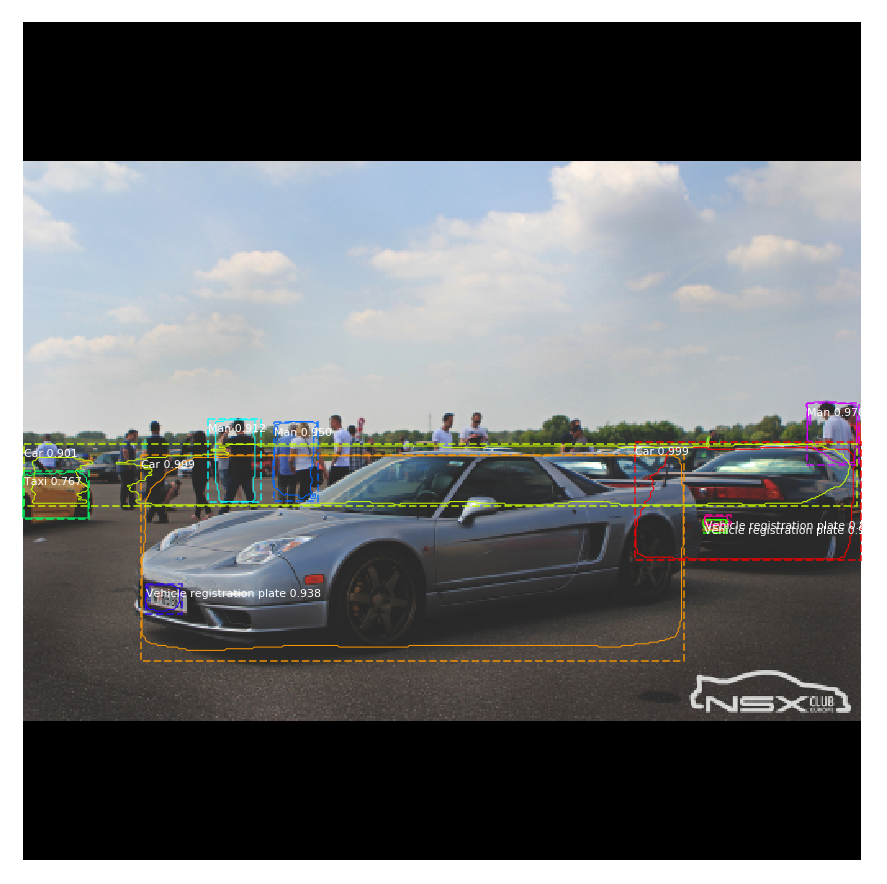

----------------- Ground Truth ---------------------


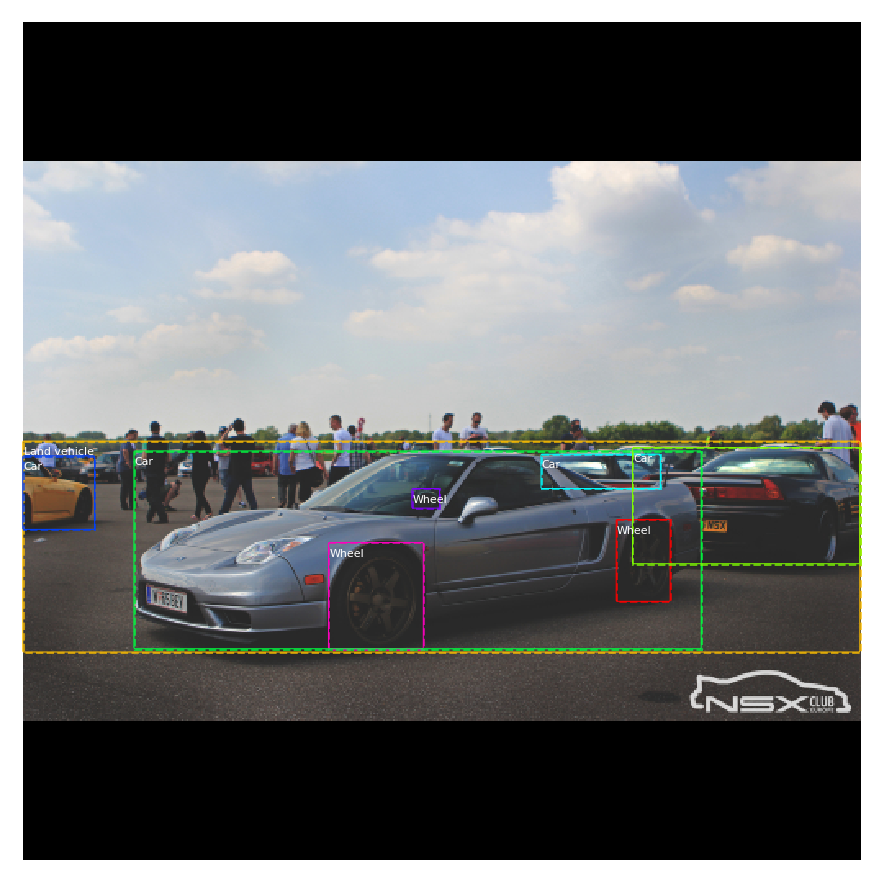

Average Precision:  0.20833333333333331
----------------- ENSEMBLE ---------------------


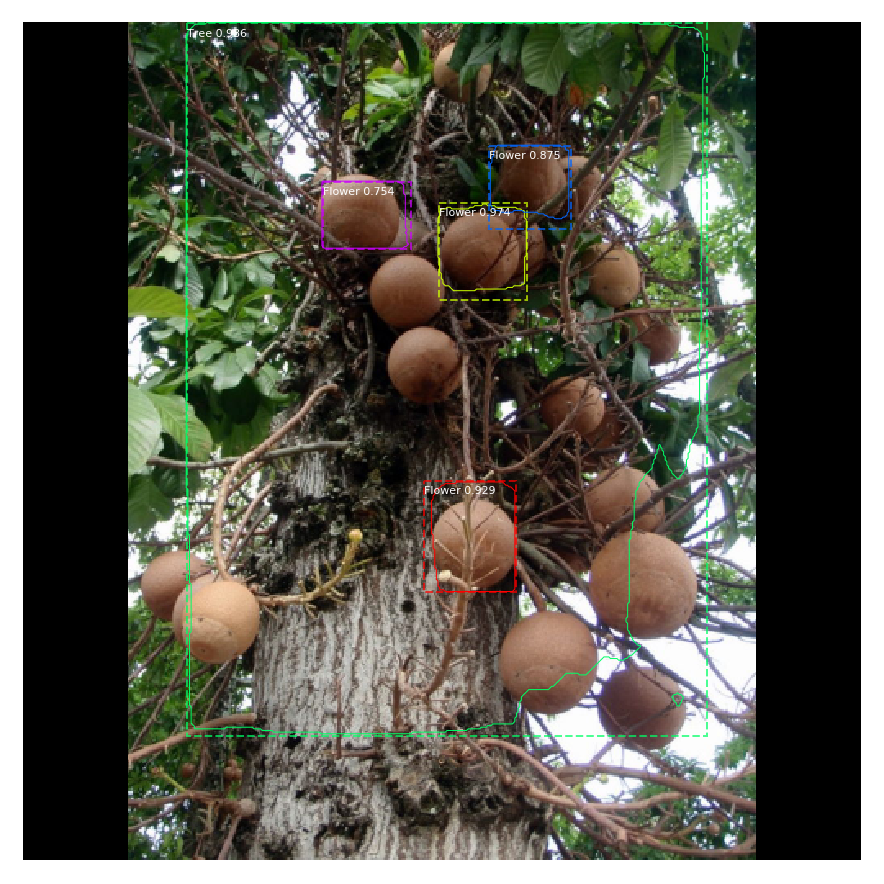

----------------- Ground Truth ---------------------


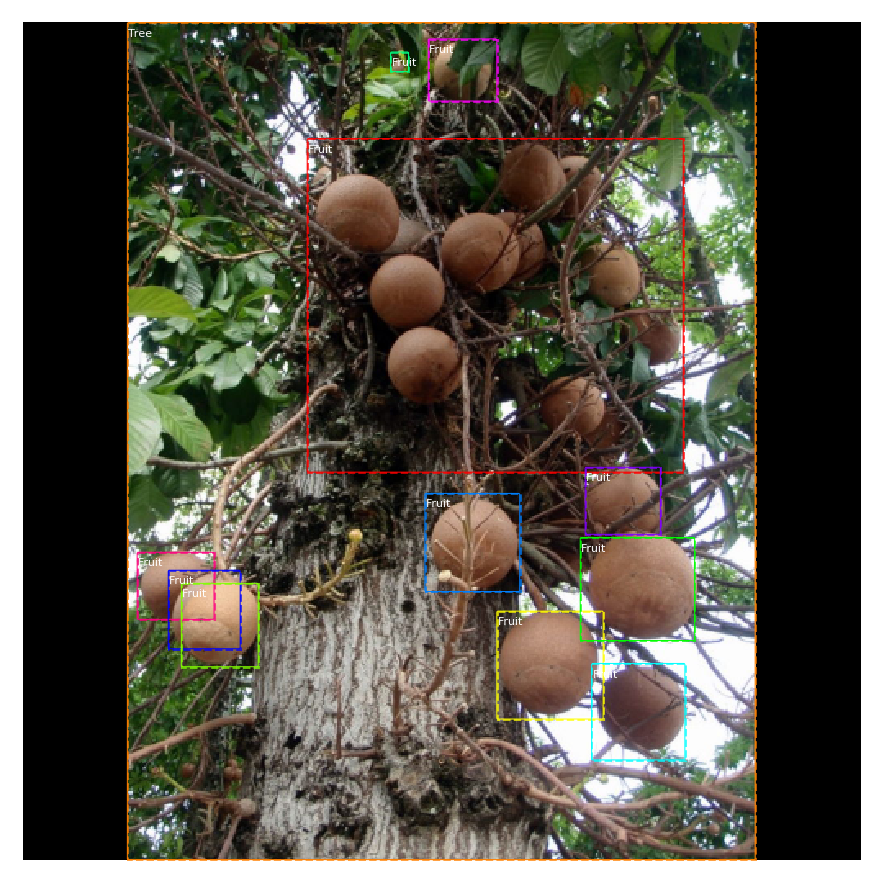

Average Precision:  0.0833333358168602
----------------- ENSEMBLE ---------------------


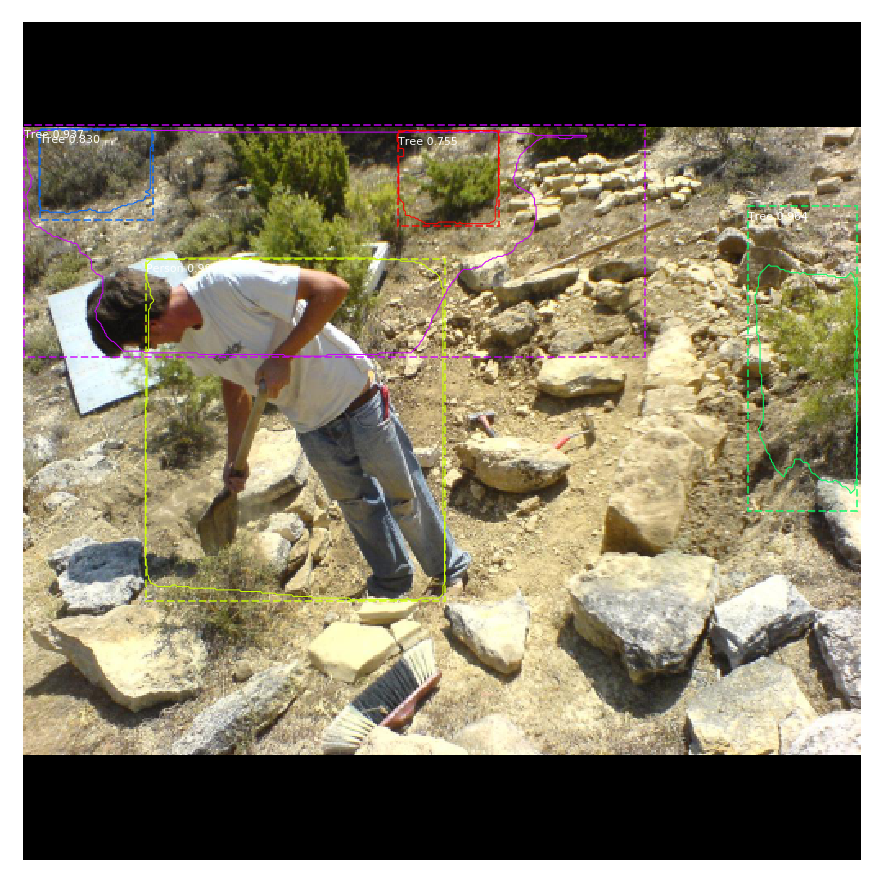

----------------- Ground Truth ---------------------


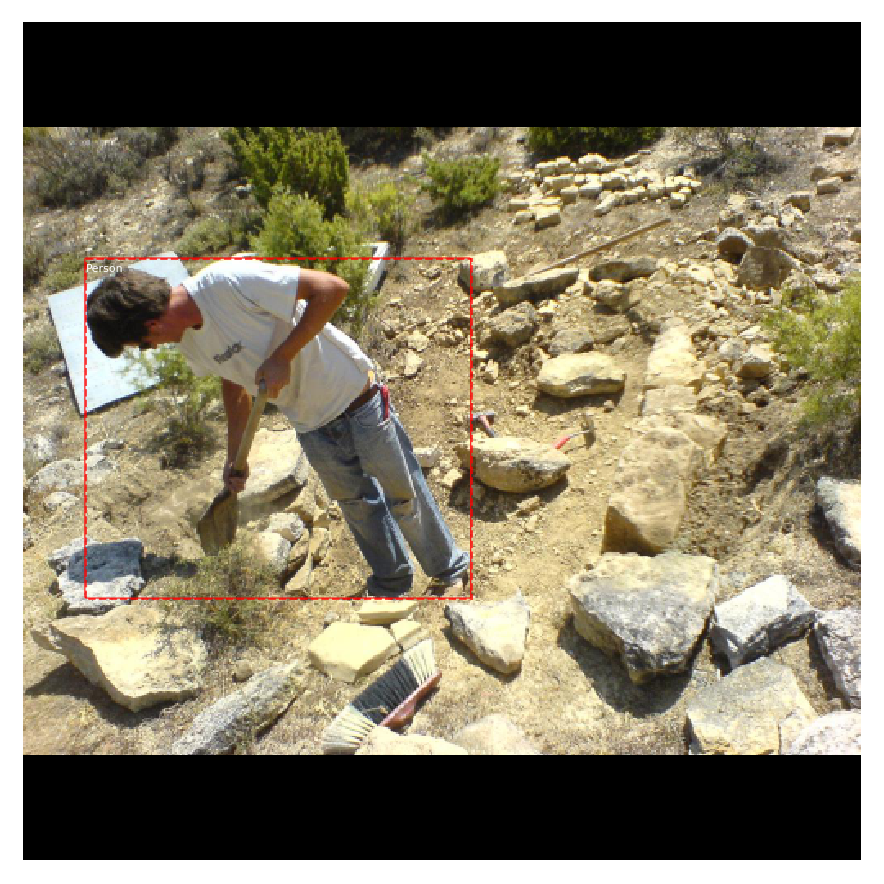

Average Precision:  1.0
----------------- ENSEMBLE ---------------------


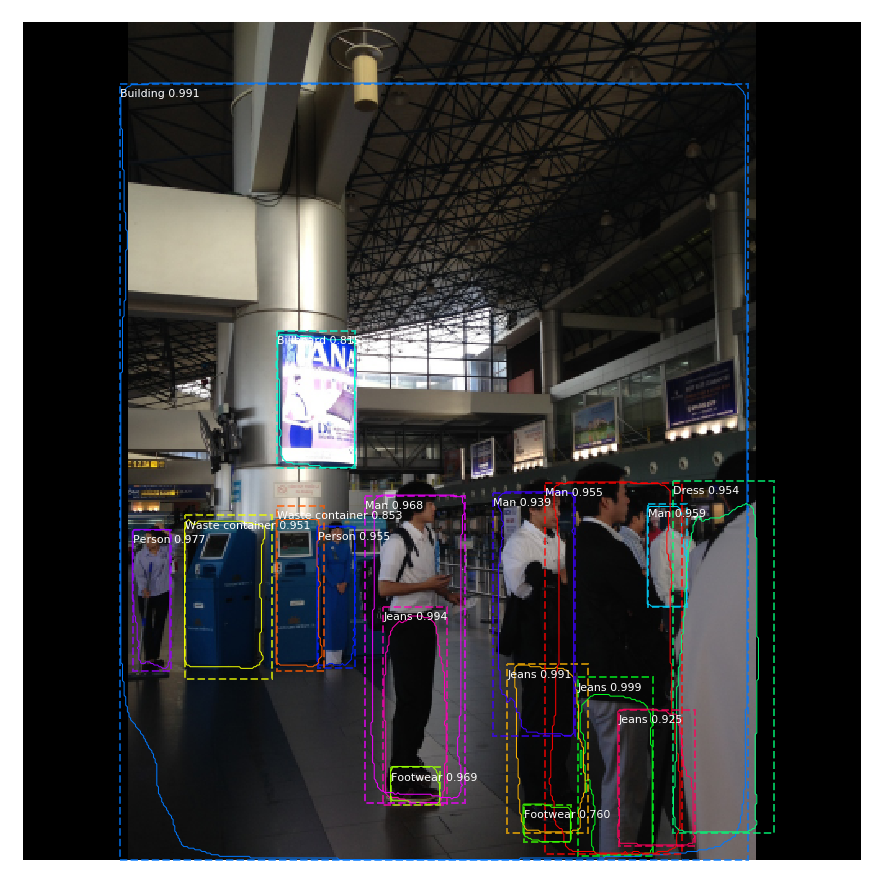

----------------- Ground Truth ---------------------


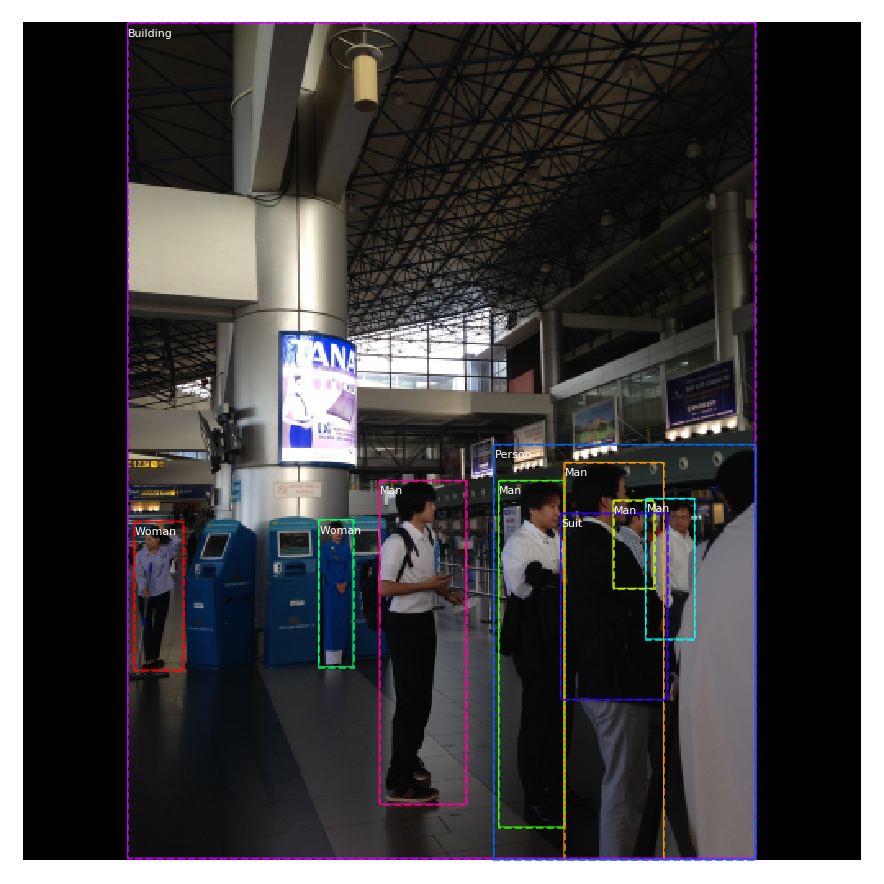

Average Precision:  0.2162393165959252


In [197]:
i = 1

for i in range(5):
    visualize_em(ver_images[i],image_ids[i],mode='ensemble')

In [156]:
omni_class_set[omni_class_set['LabelID'].isin([161,416,490,502])]

LabelName LabelDescription  LabelID
161   /m/0c568        Porcupine      161
416    /m/0jbk           Animal      416
490  /m/0c9ph5           Flower      490
502   /m/07j7r             Tree      502

### Ad hoc visualization code (moved to visualize_em function)

In [ ]:
import skimage

# img = skimage.io.imread(os.path.join(DATA_DIR, 'train/2fef4dd2f83feb18.jpg'))
# img2 = skimage.io.imread(os.path.join(DATA_DIR, 'train/55dee1384cd565ee.jpg'))


####   Use Images defined above   ####
# images = [img]

a = 1
iid = image_ids[a]
images = ver_images[a:(a+1)]

#To store each models result for each image
all_results = [[] for x in images]


for midx,model in enumerate(models):
    results = model.detect(images, verbose=0)
    
    for i in range(len(results)):
        r = results[i]
        
        r['model_id'] = midx
        r['class_ids'] += id_offsets[midx]
        
        all_results[i].append(r)
        
        visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'])

print("ENSEMBLE")
eresults = ensemble_detect(models, images,batch_size, id_offsets)
r = eresults[0]
visualize.display_instances(images[0], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'], show_mask=False)


print("Ground Truth")
inf_config = InferenceConfig()
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inf_config, iid, use_mini_mask=False)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset.class_names, figsize=(8, 8))
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names,show_mask=False)


AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                r["rois"], r["class_ids"], r["scores"], r['masks'])

print("Average Precision: ", AP)

## Evaluate mAP for member models

In [ ]:
def eval_single_model(model_path,cset_index=None, mAP_sample_size=250,class_set=None,val_data=None):

    if class_set is None:
        class_set = class_sets[cset_index]
        
    if val_data is None:
        anns = st.load_annotations_by_image(class_set)    
        val_data = st.load_dataset(anns, DATA_DIR, class_set, is_train=False)

    class KaggleConfig(TrainConfig):
        NUM_CLASSES = len(class_set) + 1 # + 1 for background class

    inf_config = KaggleConfig()
    
    inf_model = modellib.MaskRCNN(mode="inference", config=inf_config, model_dir=MODEL_DIR)

    inf_model.load_weights(model_path, by_name=True)
    
    return u.eval_mAP(inf_model, val_data, inf_config, mAP_sample_size)

### Single model using recently trained model

#### Single evaluation for a single model 

In [ ]:
eval_single_model(os.path.join(MODEL_DIR,'kaggle20190903T1053',"mask_rcnn_kaggle_0165.h5"),cset_index=2, mAP_sample_size=50)

#### Multiple evaluations of a single model

In [ ]:
# Build the validation data set once for faster mAP evaluation

cset_index = 2

class_set = class_sets[cset_index]
        
anns = st.load_annotations_by_image(class_set)    
val_data = st.load_dataset(anns, DATA_DIR, class_set, is_train=False)

In [ ]:

for i in range(161,162):
    print(i,eval_single_model(os.path.join(MODEL_DIR,'kaggle20190903T1053',"mask_rcnn_kaggle_0" + str(i) + ".h5"),
                  class_set=class_set, val_data=val_data, mAP_sample_size=250))

# eval_single_model(os.path.join(MODEL_DIR,'kaggle20190903T1053',"mask_rcnn_kaggle_0165.h5"),
#                   class_set=class_set, val_data=val_data, mAP_sample_size=250)
    
# copy recently trained model to models directory

#model from epoch 164 had mAP of 0.189, val_loss of 2.00
#model from epoch 165 had mAP of 0.271, val_loss of 1.322
#model from epoch 166 had mAP of 0.29, val_loss of 1.551
#model from epoch 74, had mAP of 0.201, val_loss of 4.6

### All models

#### Load models (duplicates cell from above)

In [ ]:
model_paths = [os.path.join(DATA_DIR,'models','cset_' + str(i) + '_model.h5') for i in range(6)]

models = load_member_models(model_paths, class_sets)

#### Run all models

In [ ]:
for i,mpath in enumerate(model_paths):
    print(i, eval_single_model(mpath,cset_index=i))